### original set of equations
$$
c_s\dot{T}_s = \beta  ln( \frac{C_a}{C_a^0} + 1 ) - \lambda  (T_s) - \lambda_*  (T_s - T_d)  - \eta_H  (T_s - T_d)
$$
$$
c_d\dot{T}_d = \eta_H  ( T_s - T_d )
$$
$$
\dot{C}_l = \Pi^0  \bigg[ (1 + \beta_\Pi  ln \big( \frac{C_a}{C_a^0} + 1 \big) \bigg] - \frac{C_l + C_l^0}{(\tau_l^0  \chi^( \frac{-T_s}{10} ) } 
$$
$$
\dot{C}_s = \gamma  \bigg( \frac{C_a}{k_a} - \frac{C_s}{k_o} \bigg)
$$
$$
\dot{C}_d = \eta_C  \bigg( \frac{C_s}{\delta} - \frac{C_d}{1 - \delta} \bigg)
$$
$$
\dot{C}_a = \mathcal{J}(t) - \dot{C}_a - \dot{C}_s - \dot{C}_d
$$

In [2]:
import sympy as sym

def sec2yr(s):
    return s * 60 * 60 * 24 * 365
def yr2sec(y):
    return y / (60 * 60 * 24 * 365)

# Sympy symbols 
# C_l, C_a, C_s, C_d, T_s = sym.symbols('C_l, C_a, C_s, C_d, T_s')
delta, eta_C = sym.symbols('\delta, \eta_C')
tau_l0, chi, C_l0, T_s = sym.symbols('\\tau_l^0 \chi C_l^0 T_s')
beta_P, beta, C_a0, preInd = sym.symbols('\\beta_{\Pi} \\beta \mathcal{C}_a^0 \Pi^0')
gam, k_a, k_o = sym.symbols('\gamma, \mathcal{k}_a \mathcal{k}_o')
A_tot, t_opt, t = sym.symbols('A_{tot}, t_{opt}, t')
eta_H = sym.Symbol('\eta_H')
lam, lam_st = sym.symbols('\lambda, \lambda_*')
delta, c_star = sym.symbols('\delta, c_*')

# values those symbols that are constants or parameters to be set
constants = {
    chi    : 1.8, # scaling factor for soil carbon lifetime decrease. empirically set to 1.8 (S
    tau_l0 : 41, # years 
    # C_l0   : 2500,  # GtCO2 (Sec 7.1)  
    C_l0   : 2460,  # GtCO2 tuned to get rid of initial exchange
    preInd : 60, # GtC/yr
    beta_P : 0.4, # co2 fertilisation factor
    # C_a0   : 37000 / 7, # GtC, estimate as 1/7 of ocean reservoir as given in paragraph 7.2
    C_a0   : 2.12 * 280,
    k_a    : 2.12, # GtC/ppm (page 41)
    # k_o    : 2.12 * (1-1/7)/(1/7) * 0.015,
    # k_o    : 2.12, # proposed by Victor
    k_o    : 2.0421, # also proposed by Victor via Mattermost, apparentyl the equation missed a Revelle factor
    gam    : 0.005, # GtC/year/ppm
    t_opt  : 250,  # years, time scale of emission
    A_tot  : 5000,  # GtC total emission
    # A_tot  : 100000,  # GtC total emission
    delta  : 0.015,  # Surface ocean fraction
    # eta_C  : 60e-12,  # [s^-1] Surface-deep ocean carbon exchange coefficient
    eta_C  : sec2yr(60e-12), # [yr^-1] Surface-deep ocean carbon exchange coefficient
    # eta_H  : 1, # enthalpy exchange coefficient
    eta_H  : 0.73, # enthalpy exchange coefficient, as proposed by Moritz
    beta   : 5.77, # W m-2 ; CO2 radiative forcing strength
    # lam    : 0.0, # W m-1 K-2 ; Radiative response to surface temperature anomaly
    lam    : 1.77, # W m-1 K-2 ; Radiative response to surface temperature anomaly
    # lam_st : 0, # W m-1 K-2 ; Radiative response to surface-deep ocean equilibrium, tunable parameter
    lam_st : 0.75, # W m-1 K-2 ; Radiative response to surface-deep ocean equilibrium, tunable parameter
    delta  : 0.015, # surface ocean fraction (of all ocean)
    # c_star : sec2yr(10.8e9), # J K-1 m-2 ; area specific heat of sea water
    c_star : yr2sec(108e8), # J K-1 m-2 ; area specific heat of sea water
}

def fetch_constants(symbol_set):
    # returns a subset of the global constants
    global constants
    c = dict()
    for s in symbol_set:
        c[s] = constants[s]
    return c



def radiation_term():
    T_s, T_d, C_a, cap = sym.symbols('T_s, T_d, C_a, c') 
    global lam, lam_st, beta, C_a0, k_a
    constants = fetch_constants([lam, lam_st, beta, C_a0, k_a])
    expr = (- (lam * (T_s)) - (lam_st * (T_s - T_d)) + (beta * sym.log( C_a / C_a0 + 1 ))) / cap
    return sym.lambdify((T_s, T_d, C_a, cap), expr.subs(constants))

def radiation_term_no_deep():
    T_s, T_d, C_a, cap = sym.symbols('T_s, T_d, C_a, c') 
    global lam, lam_st, beta, C_a0, k_a
    constants = fetch_constants([lam, lam_st, beta, C_a0, k_a])
    expr = ((beta * sym.log( C_a / C_a0 + 1 )) - (lam * (T_s)) ) / cap
    return sym.lambdify((T_s, C_a, cap), expr.subs(constants))

# this performs thermal conduction between two layers (Eq. 6.14), also used as part of Eq. 6.13
def enthalpy_exchange():
    T_s, T_d, cap = sym.symbols('T_s, T_d, c') 
    global eta_H
    constants = fetch_constants([eta_H])
    expr = eta_H * (T_s - T_d) / cap
    return sym.lambdify((T_s, T_d, cap), expr.subs(constants))

def carbon_flux_surface_deep():
    # carbon flux between the surface and deep ocean (C_d)
    C_s, C_d = sym.symbols('C_s, C_d') 
    global delta, eta_C
    constants = fetch_constants([delta, eta_C])
    expr = eta_C * (C_s / delta - C_d / (1 - delta)) # Eq. 7.11 / 8.5
    return sym.lambdify((C_s, C_d), expr.subs(constants))

def land_carbon_uptake():
    # Heterotrophic (soil) respiration (Eq. 7.5)
    C_l, C_a, T_s = sym.symbols('C_l, C_a, T_s') # as by model design: T_s == T_l
    global tau_l0, chi, C_l0
    Rh_constants = fetch_constants([tau_l0, chi, C_l0])
    Rh_expr = (C_l + C_l0)/(tau_l0 * chi **( -T_s / 10 ))
    # global net primary productivity (Eq. 7.4)
    global beta_P, C_a0, preInd
    P_constants = fetch_constants([beta_P, C_a0, preInd])
    P_expr = preInd * (1 + beta_P * sym.ln(C_a/C_a0 + 1))
    # unified function is land carbon uptake flux (Eq. 7.3) 
    return sym.lambdify((C_l,C_a,T_s), (P_expr - Rh_expr).subs(P_constants | Rh_constants))

def land_carbon_uptake_vari_beta_chi():
    # a version of the function above, that does not assume constant values for beta_P and chi
    # Heterotrophic (soil) respiration (Eq. 7.5)
    C_l, C_a, T_s = sym.symbols('C_l, C_a, T_s') # as by model design: T_s == T_l
    global tau_l0, chi, C_l0
    Rh_constants = fetch_constants([tau_l0, C_l0])
    Rh_expr = (C_l + C_l0)/(tau_l0 * chi **( -T_s / 10 ))
    # global net primary productivity (Eq. 7.4)
    global beta_P, C_a0, preInd
    P_constants = fetch_constants([C_a0, preInd])
    P_expr = preInd * (1 + beta_P * sym.ln(C_a/C_a0 + 1))
    # unified function is land carbon uptake flux (Eq. 7.3) 
    return sym.lambdify((C_l,C_a,T_s,beta_P,chi), (P_expr - Rh_expr).subs(P_constants | Rh_constants))

def atmosphere_ocean_exchange():
    # model of atmosphere ocean exchange of CO2 J_{a-s} (Eq. 7.9)
    C_a, C_s = sym.symbols('C_a, C_s') 
    global gam, k_a, k_o
    constants = fetch_constants([gam, k_a, k_o])
    expr = gam * ((C_a/k_a) - (C_s/k_o))
    return sym.lambdify((C_a, C_s), expr.subs(constants))

def gammavar_atmosphere_ocean_exchange(gamma):
    # model of atmosphere ocean exchange of CO2 J_{a-s} (Eq. 7.9)
    C_a, C_s = sym.symbols('C_a, C_s') 
    global gam, k_a, k_o
    constants = fetch_constants([gam, k_a, k_o])
    # victor suggested, that the surface ocean - amtmosphere coupling is too sluggish
    # so i play around a little:
    constants[gam] = gamma

    expr = gam * ((C_a/k_a) - (C_s/k_o))
    return sym.lambdify((C_a, C_s), expr.subs(constants))

def anthropogenic_emission():
    # Anthropogenic emissions (A(t)), Eq. (7.17)
    t = sym.Symbol('t')
    global A_tot, t_opt
    constants = fetch_constants([A_tot, t_opt])
    expr = A_tot * ((1 / (1 + 2.5 * sym.exp((t_opt - t)/50))) - (1 / (1 + 2.5 * sym.exp(t_opt / 50))))
    expr_dt = sym.Derivative(expr,t).doit()
    return sym.lambdify((t), expr_dt.subs(constants))

def emission_function(A_tot=5000, t_opt=250, stretch=50):
    # above emission function in a more flexible definition
    # used for negative emissions and emissions over larger time frame
    t = sym.Symbol('t')
    expr = A_tot * ((1 / (1 + 2.5 * sym.exp((t_opt - t)/stretch))) - (1 / (1 + 2.5 * sym.exp(t_opt / stretch))))
    expr_dt = sym.Derivative(expr,t).doit()
    return sym.lambdify((t), expr_dt.subs(constants))

def no_emission():
    def zero(t):
        return 0
    return zero

def instantaneous_emission():
    def insta(t):
        if t == 1:
            return constants[A_tot]
        else:
            return 0
    return insta

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

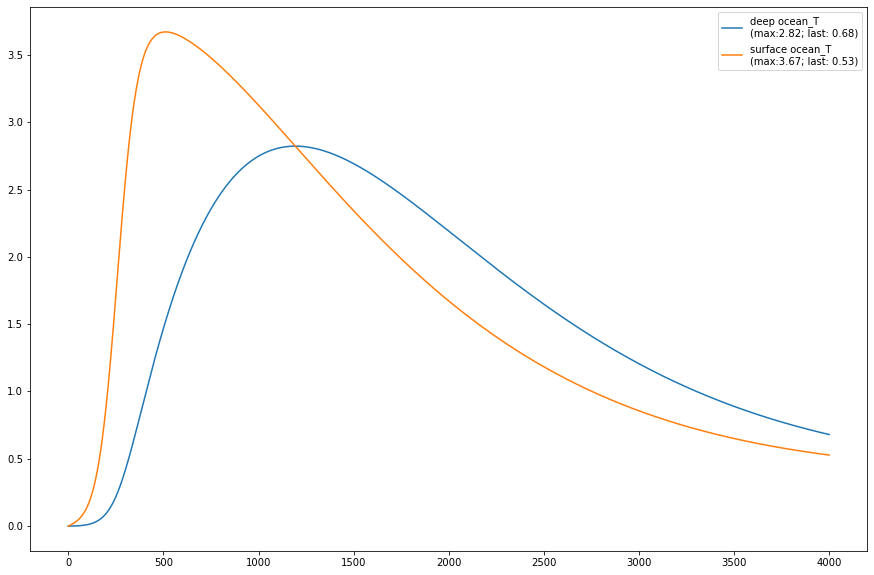

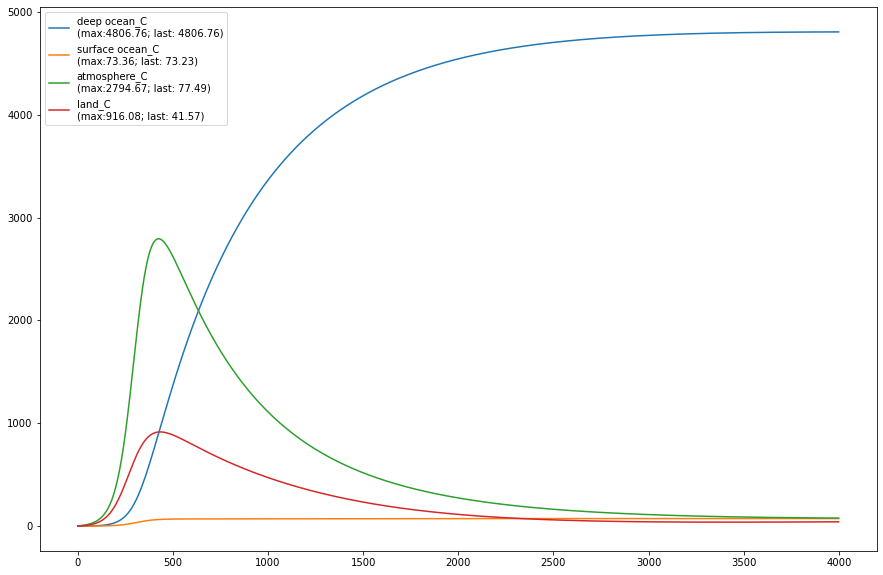

In [5]:
from boxmodel import BoxModel

model = BoxModel(step=(4000,1))

model.add_box('deep ocean',    {'C':0.0, 'T': 0.0, 'c':(1 - constants[delta]) * constants[c_star]})
model.add_box('surface ocean', {'C':0.0, 'T': 0.0, 'c':constants[delta]      * constants[c_star]})
model.add_box('atmosphere',    {'C':0.0} )
model.add_box('land', {'C':0.0 } )


model.boxes['deep ocean'].add_process('ocean circulation', 'T', enthalpy_exchange(), 
                                           [ model.boxes['surface ocean'].attr['T'], 
                                             model.boxes['deep ocean'].attr['T'],
                                             model.boxes['deep ocean'].attr['c']
                                           ], sign='+')
model.boxes['surface ocean'].add_process('ocean circulation', 'T', enthalpy_exchange(), 
                                           [ model.boxes['surface ocean'].attr['T'], 
                                             model.boxes['deep ocean'].attr['T'],
                                             model.boxes['surface ocean'].attr['c']
                                           ], sign='-')
model.boxes['deep ocean'].add_process('carbon flux', 'C', carbon_flux_surface_deep(), 
                                           [ model.ref('surface ocean_C'),
                                             model.ref('deep ocean_C')
                                           ], sign='+')
model.boxes['surface ocean'].add_process('carbon flux', 'C', carbon_flux_surface_deep(), 
                                           [ model.ref('surface ocean_C'),
                                             model.ref('deep ocean_C')
                                           ], sign='-')

model.boxes['surface ocean'].add_process('radiation', 'T', radiation_term(), 
                                           [ model.ref('surface ocean_T'), 
                                             model.ref('deep ocean_T'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_c')
                                           ])
model.boxes['surface ocean'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='-')

model.boxes['atmosphere'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='-')

model.boxes['land'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='+')

model.boxes['atmosphere'].add_process('emission', 'C', emission_function(5000,250,50), 
                                           [ model.current_time,
                                           ], sign='+') 
model.boxes['atmosphere'].add_process('negative_emission', 'C', emission_function(-5000,7500,50), 
                                           [ model.current_time,
                                           ], sign='+')
        
model.run()
model.plot(var=['deep ocean_T', 'surface ocean_T' ])
model.plot(var=['deep ocean_C', 'surface ocean_C', 'atmosphere_C', 'land_C' ])